# American Sign Language Translator
### Dataset source: https://www.kaggle.com/grassknoted/asl-alphabet/

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
# from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# path for the images
train_dir = 'data/asl_alphabet_train'
test_dir = 'data/asl_alphabet_test'

uniq_labels = sorted(os.listdir(train_dir))

### Plotting one image from each class

unique_labels =  ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


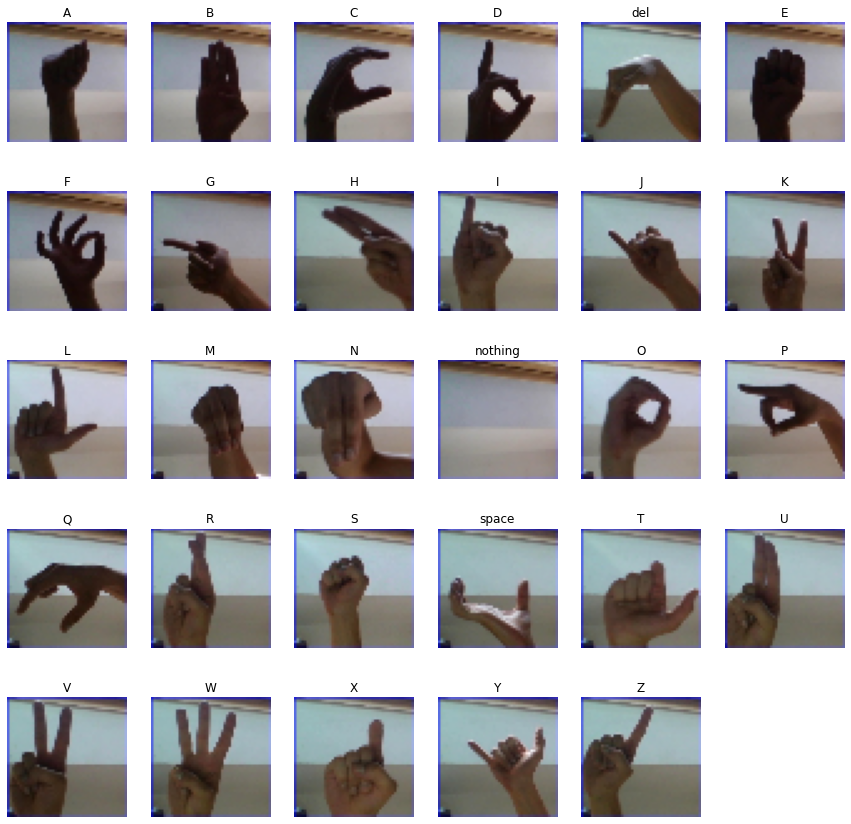

In [2]:
def load_unique():
    size_img = 48, 48
    images_for_plot = []
    labels_for_plot = []
    
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15, 15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1

plt.savefig('plot.png')
plt.show()


### Load data, preprocess, and split into training and validation

In [13]:
image_generator = ImageDataGenerator(validation_split = 0.2)

train_dataset = image_generator.flow_from_directory(batch_size = 32,
                                                    directory = train_dir,
                                                    shuffle = True, # change to True if training model, False for plotting
                                                    target_size = (48, 48), 
                                                    subset = "training",
                                                    class_mode = 'categorical',
                                                    color_mode="grayscale")

validation_dataset = image_generator.flow_from_directory(batch_size = 32,
                                                    directory = train_dir,
                                                    shuffle = False, # False for plotting confusion matrix
                                                    target_size = (48, 48), 
                                                    subset = "validation",
                                                    class_mode = 'categorical',
                                                    color_mode="grayscale")

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


### Compile model

In [4]:
# model from https://towardsdatascience.com/from-raw-images-to-real-time-predictions-with-deep-learning-ddbbda1be0e4
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 29

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Train model

In [5]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator = train_dataset,
                    steps_per_epoch = train_dataset.n//train_dataset.batch_size,
                    epochs = 5,
                    validation_data = validation_dataset,
                    validation_steps = validation_dataset.n//validation_dataset.batch_size,
                    callbacks = callbacks_list)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
2175/2175 [==============================] - 1642s 755ms/step - loss: 1.9956 - accuracy: 0.4128 - val_loss: 1.8689 - val_accuracy: 0.4272
Epoch 2/5
2175/2175 [==============================] - 1638s 753ms/step - loss: 0.6567 - accuracy: 0.7955 - val_loss: 1.3711 - val_accuracy: 0.5982
Epoch 3/5
2175/2175 [==============================] - 1621s 745ms/step - loss: 0.3034 - accuracy: 0.9059 - val_loss: 0.7858 - val_accuracy: 0.7596
Epoch 4/5
2175/2175 [==============================] - 1694s 779ms/step - loss: 0.1676 - accuracy: 0.9482 - val_loss: 0.7064 - val_accuracy: 0.8094
Epoch 5/5
2175/2175 [==============================] - 1660s 763ms/step - loss: 0.1089 - accuracy: 0.9670 - val_loss: 0.5934 - val_accuracy: 0.8259


In [6]:
# model.save('asl_classifier.h5')
# model = keras.models.load_model('asl_classifier.h5')
# keras.backend.clear_session()

### Training results

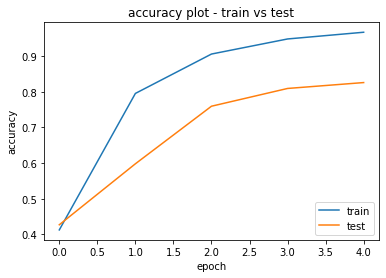

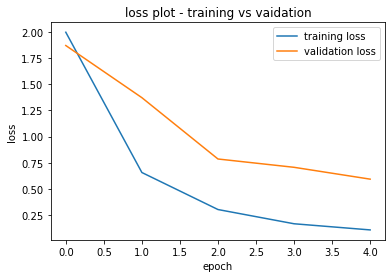

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('accuracy_plot.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('loss_plot.png')
plt.show()

### Evaluating trained model on validation data

In [8]:
evaluate_metrics = model.evaluate(validation_dataset)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),
      "\nEvaluation Loss = " ,"{:.6f}".format(evaluate_metrics[0]))


544/544 [==============================] - 68s 126ms/step - loss: 0.5935 - accuracy: 0.8259

Evaluation Accuracy =  82.59% 
Evaluation Loss =  0.593460


### Confusion Matrix

Validation Data


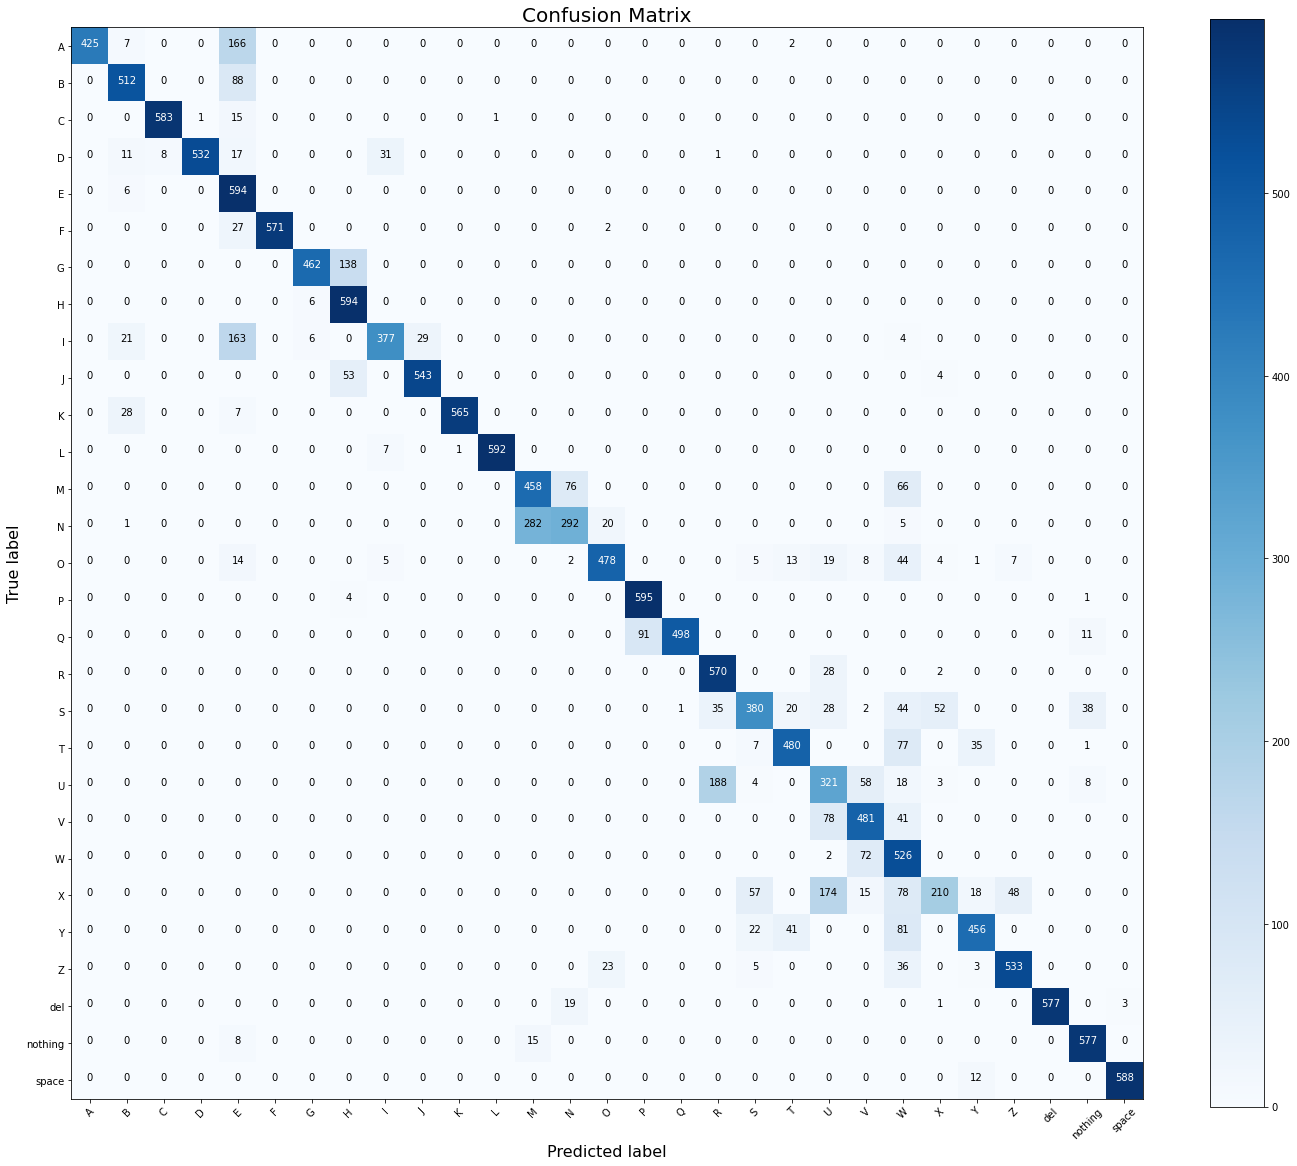

In [14]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.savefig('valid_conf_matrix.png')
    plt.show()
    
# print('Train Data')
# y_test_pred = model.predict_classes(train_dataset)
# plot_confusion_matrix(train_dataset.classes, y_test_pred)

print('Validation Data')
y_test_pred = model.predict_classes(validation_dataset)
plot_confusion_matrix(validation_dataset.classes, y_test_pred)


### Classification Report

In [10]:
print(classification_report(validation_dataset.classes, y_test_pred, target_names = uniq_labels))

              precision    recall  f1-score   support

           A       0.04      0.03      0.03       600
           B       0.03      0.03      0.03       600
           C       0.03      0.03      0.03       600
           D       0.03      0.03      0.03       600
           E       0.03      0.06      0.04       600
           F       0.04      0.04      0.04       600
           G       0.03      0.03      0.03       600
           H       0.03      0.04      0.03       600
           I       0.02      0.02      0.02       600
           J       0.04      0.04      0.04       600
           K       0.05      0.04      0.04       600
           L       0.04      0.04      0.04       600
           M       0.03      0.04      0.04       600
           N       0.04      0.02      0.03       600
           O       0.04      0.03      0.04       600
           P       0.03      0.04      0.04       600
           Q       0.04      0.03      0.03       600
           R       0.03    

### Load test data from original dataset

In [11]:
images = []
names = []
size = 48,48
for image in os.listdir(test_dir):
    temp = cv2.imread(test_dir + '/' + image, cv2.IMREAD_GRAYSCALE)
    temp = cv2.resize(temp, size)
    images.append(temp)
    names.append(image)
images = np.array(images)

predictions = [model.predict_classes(image.reshape(1,48,48,1))[0] for image in images]

### Plot predictions for test data provided in dataset

In [15]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
               'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
               'Z':25,'space':26,'del':27,'nothing':28}

def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = get_labels_for_plot(predictions)

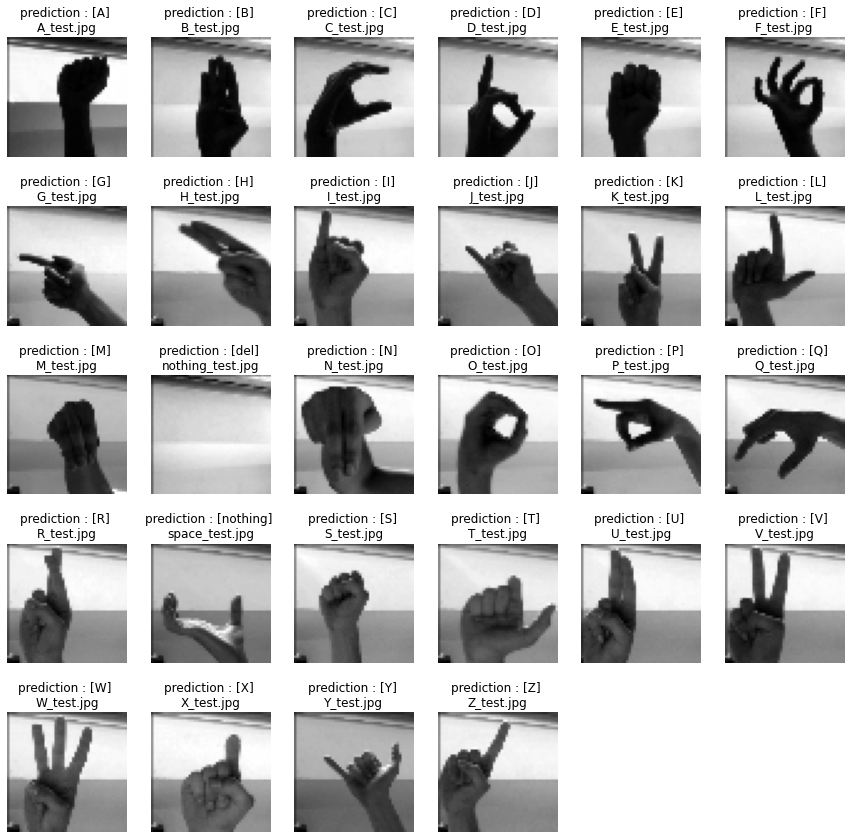

In [16]:
predfigure = plt.figure(figsize = (15,15))

def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, images[image_index], names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1

plt.savefig('predicted_plot.png')    
plt.show()